# BigTable MTLM
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [19]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

n_traits = 5



In [20]:
generate_student_name()

'PHUTHY CORE '

In [21]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }


class ProductLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, **kwargs):
        
        self.output_dim = output_dim
        super(ProductLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initializers.RandomUniform(minval=self.min_v,maxval=self.max_v),
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        
        super(ProductLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        p = x * self.kernel
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
class DifferenceLayer(Layer):

    def __init__(self, output_dim, kernel_constraint=WeightClip(min_w=-4.0, max_w=4.0), minv=-4,maxv=4, invert=False, **kwargs):
        
        self.output_dim = output_dim
        super(DifferenceLayer, self).__init__(**kwargs)
        self.kernel_constraint= constraints.get(kernel_constraint)
        self.min_v = minv
        self.max_v = maxv
        self.invert = invert

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        initialiser = initializers.RandomUniform(minval=self.min_v,maxval=self.max_v)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(1, self.output_dim),
                                      initializer=initialiser,
#                                       initializer=initializers.Constant(value=2.0),
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        super(DifferenceLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        if self.invert:
            x = tf.Print(x, [x], message="x is:", first_n=-1, summarize=1024)
            k = tf.Print(self.kernel, [self.kernel], message="- kernel is:", first_n=-1, summarize=1024)
            p = x - k
        else:
            k = tf.Print(self.kernel, [self.kernel], message="kernel is:", first_n=-1, summarize=1024)
            x = tf.Print(x, [x], message="- x is:", first_n=-1, summarize=1024)
            p = k - x
#         p = K.print_tensor(p, message="p is:")
        p =  tf.Print(p, [p], message="p is:", first_n=-1, summarize=1024)
        print("shape p", p.shape)
        return p

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [22]:
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )
    
    
# q_p_avg = 0.45

q_p_easiest = 0.95
q_p_hardest = 0.05

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/n_traits)
pr_k_hardest = q_p_hardest**(1/n_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
k_delta_easiest = inv_sigmoid(pr_k_easiest)
k_delta_hardest = inv_sigmoid(pr_k_hardest)

print("delz", k_delta_easiest, k_delta_hardest)
import math

spread = k_delta_easiest - k_delta_hardest
print("spread",spread)

beta_min = 0 #math.floor(0)
beta_max = 6 #math.ceil(beta_min + spread/2.0)

theta_min = 4 # math.floor(beta_max + spread/2.0)
theta_max = 11 # theta_min + math.ceil(k_delta_easiest)

print("th", theta_min, theta_max)
print("b", beta_min, beta_max)

max_comp_prob = 1/(1+exp(-(theta_max - beta_min)))
min_comp_prob = 1/(1+exp(-(theta_min - beta_max)))

print("max prob (rnd)", max_comp_prob)
print("min prob (rnd)", min_comp_prob)

print("max actl prob", (max_comp_prob)**n_traits)
print("min actl prob", (min_comp_prob)**n_traits)

-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
delz 4.57449944703794 0.19776312285258732
spread 4.376736324185353
th 4 11
b 0 6
max prob (rnd) 0.999983298578152
min prob (rnd) 0.11920292202211755
max actl prob 0.9999164956800886
min actl prob 2.4067695430805056e-05


In [23]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        print("call kk", self.kernel.shape)
        selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
# #         row = tf.gather(self.kernel, [selector], axis=0)
#         rows = self.kernel[selector]
#         rows = tf.gather(self.kernel, selector, axis=1)
        rows = K.gather(self.kernel, selector)
        rows = K.reshape(rows, (-1,self.dim[1]))
#         rows = K.flatten(rows)
# #         row = self.kernel
        rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
#         rows = self.kernel
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [24]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        self.id = qix
#         no_dummies = randint(1,(nt-1))
#         print("no_dummies=",no_dummies)
#         not_present=-20
#         min_diff = 0
#         max_diff = 10
#         self.betas = [ not_present for _ in range(nt) ]
        self.betas = [randint(min_diff,max_diff) for _ in range(nt)]


In [25]:
class Student():
    def __init__(self, psix, min_abil, max_abil, nt=None, nnw=None, optimiser=None):
        #self.MAX_BETA = 15
        self.id = psix
        self.name = generate_student_name()
#         min_abil = 0
#         max_abil = 10
        self.thetas = [ randint(min_abil, max_abil) for _ in range(nt) ]
#         self.mastery = [0 for _ in range(nq)]
#         self.o_practice = [0 for _ in range(nq)]
#         self.h_practice = [0 for _ in range(nt)]
        #print("Made q with betas:", self.betas)


In [26]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=True
#         student.mastery[q.id] = 1
    else:
        passed=False

    return passed

In [27]:
def calculate_pass_probability(thetas, betas):
    # additive factors model is:
    # p_pass = 1 / 1 + exp(-z)
    # where z = a + sum[1:n]( -b + gT )
    
    p_pass = 1.0
#     print("th,b",thetas,betas)
    for th,b in zip(thetas,betas):
#         if b < 0:
#             continue
        z = (th-b)
        p_pass_step = 1.0 / (1.0 + exp(-z))
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:        
        print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [28]:
qopt = Adam()

def create_qs(n_qs, nt=n_traits, nnw=n_traits, optimiser=qopt):
    random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw, optimiser=optimiser) for qix in range(n_qs)]
    for q in master_qs:
        nocomps = len(q.betas)
        mag = sqrt(sum([ pow(b, 2) for b in q.betas if b!=-10 ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, nocomps))
    
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [29]:
psi_opt = Adam()
def create_students(n_students, nt=n_traits, nnw=n_traits, optimiser=None):
    random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw, optimiser=optimiser) for psix in range(n_students)]
    for psi in psi_list:
        print(psi.name, psi.thetas)
        
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
    
    return psi_list, psi_table
    

In [30]:
extend_pop=False
extend_by = 90
if extend_pop:
    for _ in range(extend_by):
        nu_psi = Student(nt=n_traits, nq=len(master_qs), optimiser=psi_opt)
        psi_list.append(nu_psi)

In [31]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]

    user_budget = 100
    user_patience = 10
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            #psi.mastery = [0 for _ in range(nq)]
            qs = [ix for ix in range(len(master_qs))]
            print("* * * **** USER {}".format(psi.name))
            print("* * * * ** THETAS {}".format(psi.thetas))

            while(True):
                q_ct = 0
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=False

#                 if psi.name not in attempts_by_psi:
#                     attempts_by_psi[psi.name]=[]

#                 if q not in attempts_by_q:
#                     attempts_by_q[q]=[]

                while not passed and q_ct<user_patience:
                    passed = attempt_q(psi, q)
                    tup = (psi.id, q.id, passed)
                    #attempts.append(tup)
#                     attempts_by_psi[psi.name].append(tup)
#                     attempts_by_q[q].append(tup)
                    attempts.append(tup)
                    q_ct+=1

                if passed:
                    #print("passed")
                    qs.remove(qix)

                spend += 1

                if qs == [] or spend>=user_budget:
                        print("* ** *QFIN USER {}".format(psi.name))
                        break
    gc.collect()
    return attempts

def generate_q_model(qn_table, optimiser):
    thetas_in = Input(shape=n_traits, name="thetas_in")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    qn_row = qn_table(qn_sel)
    dif = subtract([thetas_in, qn_row])
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model  

def generate_psi_model(psi_table, optimiser):
    betas_in = Input(shape=n_traits, name="thetas_in")
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    psi_row = psi_table(psi_sel)
    dif = subtract([psi_row, betas_in])
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model  

    
def generate_model(qn_table, psi_table, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)
# #     qn_row = Lambda(lambda q: q[:,qn_sel,:])(qn_table)
# #     psi_row = Lambda(lambda s: s[:,psi_sel,:])(psi_table)
#     print("shape qn_row",qn_row.shape)
#     print("shape psi row", psi_row.shape)
#     qn_row = Lambda(lambda q: tf.Print(q, [q], message="qn row is:", first_n=-1, summarize=1024))(qn_row)
#     psi_row = Lambda(lambda q: tf.Print(q, [q], message="psi row is:", first_n=-1, summarize=1024))(psi_row)
#     qn_row = Reshape((1,))(qn_row)
# #     psi_row = Reshape((1,))(psi_row)
    
# #     qn_row = Flatten()(qn_row)
# #     psi_row = Flatten()(psi_row)
#     print("psi row shape", psi_row.shape)
#     print("qn_eow shape", qn_row.shape)
#     dif = subtract([psi_sel, qn_sel])
    dif = subtract([psi_row, qn_row])
#     dif = concatenate([qn_row, psi_row])
#     dif = Lambda(lambda a: a[0] - a[1])([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)
#     print("Prs",Prs.shape)
    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model
    

In [32]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, attempts, psi_wgts, qn_wgts, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="loss", mode="auto", patience=3)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = 1000
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    
    qices = array([int(tup[1]) for tup in attempts])
    psices = array([int(tup[0]) for tup in attempts])
    pfs = array([int(tup[2]) for tup in attempts])
    print(qices.shape)
    print(psices.shape)
    print(pfs.shape)
#     input("chuff")

    print("PRE WEIGHTS")
    for psi in psi_list:
        print("psi",psi.id," -> ",psi_wgts[psi.id])

    for qn in master_qs:
        print("qn",qn.id," -> ",qn_wgts[qn.id])
    
    
    len_all = qices.shape[0]
    batch_size = 5
    loss = False
    mse = False
    acc = False
    for i in range(n_iter):
        print("i ====",i)
        base_ix = 0
        chunkz = int(len_all/batch_size)
        print("chunkz = ", chunkz)
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        while True:
#             print("j ~~~~", j, base_ix)
            j+=1
            qz = qices[base_ix:(base_ix+batch_size)]
            sz = psices[base_ix:(base_ix+batch_size)]
            pfz = pfs[base_ix:(base_ix+batch_size)]
            
            base_ix = min(base_ix + batch_size, len_all)
            if len(qz)==0:
                break

            loss, mse, acc = qs_model.train_on_batch(x=[qz, sz], y=pfz) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))
            
            psi_wgts = s_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
                s_thetas = numpy.sort(s.thetas)
                s_wgts = numpy.sort(psi_wgts[s.id])
                err = numpy.power(s_thetas - s_wgts, 2)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
                q_betas = numpy.sort(q.betas)
                q_wgts = numpy.sort(qn_wgts[q.id])
                err = numpy.power(q_betas - q_wgts, 2)
                b_rmses.append(err)

            
        th_rmse = numpy.sqrt(numpy.mean(numpy.ravel(th_rmses)))
        th_fit_rmses.append(th_rmse)
        print("th RMSE=", th_rmse)
        b_rmse = numpy.sqrt(numpy.mean(numpy.ravel(b_rmses)))
        b_fit_rmses.append(b_rmse)
        print("b RMSE=", b_rmse)
        sub_h = numpy.array(sub_h)
        sub_tup = (numpy.mean(sub_h[:,0]),numpy.mean(sub_h[:,1]),numpy.mean(sub_h[:,2]))
        h.append(sub_tup)
            
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [36]:
nn_dimensions = [n_traits]
serieses = []
min_errs = []
n_qs = 50
n_students = 100
for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss, s_table = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts = generate_attempts(qs,ss)
#     print(attempts)
    qs_model = generate_model(q_table, s_table, qopt)
#     q_model = generate_q_model(s_table, qopt)
#     psi_model = generate_psi_model(s_table, qopt)
    psi_wgts = s_table.get_weights()[0]
    qn_wgts = q_table.get_weights()[0]
    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss,qs_model, attempts, psi_wgts, qn_wgts, n_iter=800, record_param_fit=True)


Q:0, difficulty=6.86 across 5 components
Q:1, difficulty=10.20 across 5 components
Q:2, difficulty=8.06 across 5 components
Q:3, difficulty=7.75 across 5 components
Q:4, difficulty=2.24 across 5 components
Q:5, difficulty=5.92 across 5 components
Q:6, difficulty=8.37 across 5 components
Q:7, difficulty=9.00 across 5 components
Q:8, difficulty=7.55 across 5 components
Q:9, difficulty=6.48 across 5 components
Q:10, difficulty=9.85 across 5 components
Q:11, difficulty=6.48 across 5 components
Q:12, difficulty=7.68 across 5 components
Q:13, difficulty=5.57 across 5 components
Q:14, difficulty=8.06 across 5 components
Q:15, difficulty=11.05 across 5 components
Q:16, difficulty=7.68 across 5 components
Q:17, difficulty=8.66 across 5 components
Q:18, difficulty=8.00 across 5 components
Q:19, difficulty=6.86 across 5 components
Q:20, difficulty=6.56 across 5 components
Q:21, difficulty=9.64 across 5 components
Q:22, difficulty=7.62 across 5 components
Q:23, difficulty=8.31 across 5 components


p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.06765883352054927
p_pass=0.7937859290384763
p_pass=0.6830099579222495
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.08535478962945778
p_pass=0.6116542288670863
p_pass=0.6116542288670863
p_pass=0.5664510656247563
p_pass=0.5664510656247563
p_pass=0.46716246032772535
p_pass=0.46716246032772535
p_pass=0.46716246032772535
p_pass=0.34183455301429405
p_pass=0.34183455301429405
p_pass=0.7567381425969114
p_pass=0.6804844300695856
p_pass=0.6804844300695856
p_pass=0.09629911322804886
p_pass=0.09629911322804886
p_pass=0.09629911322804886
p_pass=0.09629911322804886
p_pass=0.09629911322804886
p_pass=0.09629911322804886
p_pass=0.0

p_pass=0.48531174213503736
p_pass=0.48531174213503736
p_pass=0.48531174213503736
p_pass=0.9337216411122705
p_pass=0.9326999067835586
p_pass=0.7045243701640833
p_pass=0.7152421134477044
p_pass=0.9102115435603535
p_pass=0.8313105935747128
p_pass=0.9347711947508979
p_pass=0.9616279505541623
p_pass=0.4193198220651542
p_pass=0.9162314287576976
p_pass=0.9577351454009186
p_pass=0.8906680858256012
p_pass=0.3995672082784787
p_pass=0.9003921212368533
p_pass=0.7651968749134835
p_pass=0.9747709187546186
p_pass=0.8376979861767249
p_pass=0.8376979861767249
* ** *QFIN USER RUR CAYIP 
* * * **** USER HOLUJ CHOV 
* * * * ** THETAS [7, 5, 10, 10, 10]
p_pass=0.7751875824684266
p_pass=0.7751875824684266
p_pass=0.9733382552009772
p_pass=0.9861617369239555
p_pass=0.961600354787897
p_pass=0.9796823909247191
p_pass=0.7731450731049769
p_pass=0.4963645016454111
p_pass=0.4963645016454111
p_pass=0.9567031945668936
p_pass=0.9567031945668936
p_pass=0.4787877974782037
p_pass=0.4787877974782037
p_pass=0.2620856738416

p_pass=0.6946025121254892
p_pass=0.6946025121254892
p_pass=0.49662429534148234
p_pass=0.49662429534148234
p_pass=0.6626745664456044
p_pass=0.6626745664456044
p_pass=0.9569806858787426
p_pass=0.8679635304215205
p_pass=0.833357288033946
p_pass=0.9163029006114899
p_pass=0.2346368830047533
p_pass=0.2346368830047533
p_pass=0.2346368830047533
p_pass=0.9489916222031528
p_pass=0.6306913288844875
p_pass=0.9498557451530811
p_pass=0.8083770486748537
p_pass=0.48890077386795716
p_pass=0.4705733218187871
p_pass=0.7736850336760633
p_pass=0.9555123492274535
p_pass=0.9840533329906547
p_pass=0.9375263308883972
p_pass=0.8749417544589161
p_pass=0.8436744223934731
p_pass=0.8885754446819417
p_pass=0.9336220177414409
p_pass=0.6131601273012751
p_pass=0.1719584947397031
p_pass=0.1719584947397031
p_pass=0.1719584947397031
p_pass=0.1719584947397031
p_pass=0.1719584947397031
p_pass=0.1719584947397031
p_pass=0.8570025614889939
p_pass=0.2310367761180182
p_pass=0.2310367761180182
p_pass=0.2310367761180182
p_pass=0.2

p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.07487142379599679
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.05842285853682998
p_pass=0.22951880279278447
p_pass=0.22951880279278447
p_pass=0.22951880279278447
p_pass=0.6008543840785738
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.05372025055536914
p_pass=0.07057479771894196
p_pass=0.07057479771894196
p_pass=0.07057479771894196
p_pass=0.07057479771894196
p_

p_pass=0.11273791169801856
p_pass=0.11273791169801856
p_pass=0.11273791169801856
p_pass=0.11273791169801856
p_pass=0.11273791169801856
p_pass=0.11273791169801856
p_pass=0.6625340915565943
p_pass=0.6943469379541044
p_pass=0.9726868682766714
p_pass=0.8217949415660725
p_pass=0.8217949415660725
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.11390176637757998
p_pass=0.6927155569790133
p_pass=0.6893876500106664
p_pass=0.4295299231726939
p_pass=0.4295299231726939
p_pass=0.4295299231726939
p_pass=0.6916861700464847
p_pass=0.8756335921626762
p_pass=0.3580230592569727
p_pass=0.3580230592569727
p_pass=0.3580230592569727
p_pass=0.11484682041640537
p_pass=0.11484682041640537
p_pass=0.11484682041640537
p_pass=0.11484682041640537
p_pass=0.11484682041640537
p_pass=0.11484682041640537
p_pass=0.1148468

p_pass=0.11206910610345674
p_pass=0.7033207785887495
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.46453275304872227
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.023378376319117742
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.028361542460889917
p_pass=0.6022694272389449
p_pass=0.09526932229628365
p_pass=0.09526932229628365
p_pass=0.09526932229628365
p

p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.03013078877536162
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_pass=0.017127867219535086
p_

kk (50, 5)
selector shape (?, 1)
call kk (50, 5)
'rows' shape, (?, 5)
kk (100, 5)
selector shape (?, 1)
call kk (100, 5)
'rows' shape, (?, 5)
dif (?, 5)
Pr (?, 1)
(18613,)
(18613,)
(18613,)
PRE WEIGHTS
psi 0  ->  [ 5.77987385  8.3666544   8.06423664  9.17482471  5.14907408]
psi 1  ->  [  4.22062254  10.40628242   5.35215473   6.43875885   5.10708046]
psi 2  ->  [ 10.08032513   5.34881258   9.08516884  10.10596561   7.80909348]
psi 3  ->  [ 9.33381939  9.5104847   6.28563786  6.48182392  4.29235411]
psi 4  ->  [ 5.08145905  8.20279503  9.96595955  4.98825836  9.47210312]
psi 5  ->  [  6.29631329   8.00741768   7.70627975   6.62494993  10.28782463]
psi 6  ->  [ 4.07225132  6.6158843   7.67539883  9.73100567  8.74118996]
psi 7  ->  [ 10.62852097  10.22383308   4.12585068   8.83101654   5.63822412]
psi 8  ->  [ 5.0346508   7.43279362  7.06391764  9.18378544  9.65373611]
psi 9  ->  [  4.94829082   6.58953762   5.56455088  10.82819462   9.13648033]
psi 10  ->  [  5.29488039   8.84279346   8.

th RMSE= 1.70842361917
b RMSE= 1.52256380781
i ==== 1
chunkz =  3722
th RMSE= 1.64637660055
b RMSE= 1.45512892782
i ==== 2
chunkz =  3722
th RMSE= 1.59306948109
b RMSE= 1.41002103662
i ==== 3
chunkz =  3722
th RMSE= 1.54781594099
b RMSE= 1.38195760875
i ==== 4
chunkz =  3722
th RMSE= 1.50975403339
b RMSE= 1.36490680346
i ==== 5
chunkz =  3722
th RMSE= 1.47773145392
b RMSE= 1.35469572702
i ==== 6
chunkz =  3722
th RMSE= 1.45058998002
b RMSE= 1.3474166312
i ==== 7
chunkz =  3722
th RMSE= 1.42756142111
b RMSE= 1.34478314463
i ==== 8
chunkz =  3722
th RMSE= 1.40851154797
b RMSE= 1.34557914772
i ==== 9
chunkz =  3722
th RMSE= 1.39258923161
b RMSE= 1.34870988939
i ==== 10
chunkz =  3722
th RMSE= 1.3793221734
b RMSE= 1.35351627029
i ==== 11
chunkz =  3722
th RMSE= 1.36850578721
b RMSE= 1.35949895989
i ==== 12
chunkz =  3722
th RMSE= 1.35916542058
b RMSE= 1.36602643016
i ==== 13
chunkz =  3722
th RMSE= 1.3510797516
b RMSE= 1.37151577097
i ==== 14
chunkz =  3722
th RMSE= 1.34446251429
b RMSE= 1

th RMSE= 1.30670808669
b RMSE= 1.04746734844
i ==== 119
chunkz =  3722
th RMSE= 1.30699988858
b RMSE= 1.04466718458
i ==== 120
chunkz =  3722
th RMSE= 1.3072168527
b RMSE= 1.04194620917
i ==== 121
chunkz =  3722
th RMSE= 1.3073018265
b RMSE= 1.03943313953
i ==== 122
chunkz =  3722
th RMSE= 1.30734734335
b RMSE= 1.03714559796
i ==== 123
chunkz =  3722
th RMSE= 1.30732288834
b RMSE= 1.03487321537
i ==== 124
chunkz =  3722
th RMSE= 1.30729207134
b RMSE= 1.03278391563
i ==== 125
chunkz =  3722
th RMSE= 1.30685233856
b RMSE= 1.03094959972
i ==== 126
chunkz =  3722
th RMSE= 1.30632045319
b RMSE= 1.02938141872
i ==== 127
chunkz =  3722
th RMSE= 1.30592739715
b RMSE= 1.02806504287
i ==== 128
chunkz =  3722
th RMSE= 1.30555607052
b RMSE= 1.02700611716
i ==== 129
chunkz =  3722
th RMSE= 1.30524105648
b RMSE= 1.0262205672
i ==== 130
chunkz =  3722
th RMSE= 1.30490190954
b RMSE= 1.02567929633
i ==== 131
chunkz =  3722
th RMSE= 1.30468744715
b RMSE= 1.02537729126
i ==== 132
chunkz =  3722
th RMSE= 

th RMSE= 1.35666844952
b RMSE= 1.05909959253
i ==== 235
chunkz =  3722
th RMSE= 1.35696930714
b RMSE= 1.0590193942
i ==== 236
chunkz =  3722
th RMSE= 1.35731506211
b RMSE= 1.05899790269
i ==== 237
chunkz =  3722
th RMSE= 1.35770544178
b RMSE= 1.05901325355
i ==== 238
chunkz =  3722
th RMSE= 1.3581001017
b RMSE= 1.05855383505
i ==== 239
chunkz =  3722
th RMSE= 1.35852460834
b RMSE= 1.05796457883
i ==== 240
chunkz =  3722
th RMSE= 1.3589940623
b RMSE= 1.05735503113
i ==== 241
chunkz =  3722
th RMSE= 1.35936574951
b RMSE= 1.05679757498
i ==== 242
chunkz =  3722
th RMSE= 1.35971990663
b RMSE= 1.05629617575
i ==== 243
chunkz =  3722
th RMSE= 1.36005296645
b RMSE= 1.0558521095
i ==== 244
chunkz =  3722
th RMSE= 1.36042112629
b RMSE= 1.05539064437
i ==== 245
chunkz =  3722
th RMSE= 1.36082812867
b RMSE= 1.05466371544
i ==== 246
chunkz =  3722
th RMSE= 1.36127325618
b RMSE= 1.05398316515
i ==== 247
chunkz =  3722
th RMSE= 1.36154899227
b RMSE= 1.05334255212
i ==== 248
chunkz =  3722
th RMSE= 1

th RMSE= 1.33696143425
b RMSE= 1.03969823793
i ==== 351
chunkz =  3722
th RMSE= 1.33676961809
b RMSE= 1.040073183
i ==== 352
chunkz =  3722
th RMSE= 1.33651783091
b RMSE= 1.04045303552
i ==== 353
chunkz =  3722
th RMSE= 1.33627656235
b RMSE= 1.04084940279
i ==== 354
chunkz =  3722
th RMSE= 1.33601972044
b RMSE= 1.04126690059
i ==== 355
chunkz =  3722
th RMSE= 1.33574464551
b RMSE= 1.04170959168
i ==== 356
chunkz =  3722
th RMSE= 1.33549093174
b RMSE= 1.04217708059
i ==== 357
chunkz =  3722
th RMSE= 1.33525900357
b RMSE= 1.04249382614
i ==== 358
chunkz =  3722
th RMSE= 1.33504846584
b RMSE= 1.04279089941
i ==== 359
chunkz =  3722
th RMSE= 1.33485796674
b RMSE= 1.04300213473
i ==== 360
chunkz =  3722
th RMSE= 1.33462420439
b RMSE= 1.04322109646
i ==== 361
chunkz =  3722
th RMSE= 1.33421591234
b RMSE= 1.04345067494
i ==== 362
chunkz =  3722
th RMSE= 1.33382726461
b RMSE= 1.04348497052
i ==== 363
chunkz =  3722
th RMSE= 1.33344613704
b RMSE= 1.04355258559
i ==== 364
chunkz =  3722
th RMSE=

th RMSE= 1.27266080134
b RMSE= 1.09244648252
i ==== 467
chunkz =  3722
th RMSE= 1.27230756041
b RMSE= 1.09308323301
i ==== 468
chunkz =  3722
th RMSE= 1.27196850247
b RMSE= 1.09374531747
i ==== 469
chunkz =  3722
th RMSE= 1.27164433907
b RMSE= 1.09443336783
i ==== 470
chunkz =  3722
th RMSE= 1.27126049317
b RMSE= 1.09514755491
i ==== 471
chunkz =  3722
th RMSE= 1.27085649104
b RMSE= 1.09584226184
i ==== 472
chunkz =  3722
th RMSE= 1.27048329316
b RMSE= 1.0964819843
i ==== 473
chunkz =  3722
th RMSE= 1.27007191542
b RMSE= 1.09714985345
i ==== 474
chunkz =  3722
th RMSE= 1.26966979606
b RMSE= 1.09773653071
i ==== 475
chunkz =  3722
th RMSE= 1.26929924665
b RMSE= 1.0981323516
i ==== 476
chunkz =  3722
th RMSE= 1.26896049384
b RMSE= 1.09853101337
i ==== 477
chunkz =  3722
th RMSE= 1.26865435018
b RMSE= 1.09895222873
i ==== 478
chunkz =  3722
th RMSE= 1.26834201609
b RMSE= 1.09939607634
i ==== 479
chunkz =  3722
th RMSE= 1.26803197762
b RMSE= 1.09986390145
i ==== 480
chunkz =  3722
th RMSE=

th RMSE= 1.28427341497
b RMSE= 1.10125163428
i ==== 583
chunkz =  3722
th RMSE= 1.28468138361
b RMSE= 1.10140399182
i ==== 584
chunkz =  3722
th RMSE= 1.28509978703
b RMSE= 1.10156121184
i ==== 585
chunkz =  3722
th RMSE= 1.28552892803
b RMSE= 1.10172290399
i ==== 586
chunkz =  3722
th RMSE= 1.28596867575
b RMSE= 1.10188902751
i ==== 587
chunkz =  3722
th RMSE= 1.28641882003
b RMSE= 1.10205935154
i ==== 588
chunkz =  3722
th RMSE= 1.2868797976
b RMSE= 1.10223418226
i ==== 589
chunkz =  3722
th RMSE= 1.28735143215
b RMSE= 1.10241326854
i ==== 590
chunkz =  3722
th RMSE= 1.28783367889
b RMSE= 1.10259665191
i ==== 591
chunkz =  3722
th RMSE= 1.28832671836
b RMSE= 1.10278428749
i ==== 592
chunkz =  3722
th RMSE= 1.28883082379
b RMSE= 1.1029762636
i ==== 593
chunkz =  3722
th RMSE= 1.28934578659
b RMSE= 1.10317250186
i ==== 594
chunkz =  3722
th RMSE= 1.28987167517
b RMSE= 1.10337294349
i ==== 595
chunkz =  3722
th RMSE= 1.29040819394
b RMSE= 1.10357571706
i ==== 596
chunkz =  3722
th RMSE=

th RMSE= 1.31395097573
b RMSE= 1.13202436594
i ==== 699
chunkz =  3722
th RMSE= 1.3140219768
b RMSE= 1.13235033267
i ==== 700
chunkz =  3722
th RMSE= 1.31409653133
b RMSE= 1.13268177893
i ==== 701
chunkz =  3722
th RMSE= 1.31417466506
b RMSE= 1.13301893298
i ==== 702
chunkz =  3722
th RMSE= 1.314252999
b RMSE= 1.13336191235
i ==== 703
chunkz =  3722
th RMSE= 1.31432812164
b RMSE= 1.13371081006
i ==== 704
chunkz =  3722
th RMSE= 1.31440705808
b RMSE= 1.13406554665
i ==== 705
chunkz =  3722
th RMSE= 1.31448954508
b RMSE= 1.13442647281
i ==== 706
chunkz =  3722
th RMSE= 1.31457553896
b RMSE= 1.13479350718
i ==== 707
chunkz =  3722
th RMSE= 1.31466522816
b RMSE= 1.1351667818
i ==== 708
chunkz =  3722
th RMSE= 1.31475831271
b RMSE= 1.13554639658
i ==== 709
chunkz =  3722
th RMSE= 1.31485502258
b RMSE= 1.13593242169
i ==== 710
chunkz =  3722
th RMSE= 1.31495513271
b RMSE= 1.13632491951
i ==== 711
chunkz =  3722
th RMSE= 1.31505896327
b RMSE= 1.13672400676
i ==== 712
chunkz =  3722
th RMSE= 1

elements in h: 800
(1.0124718, 0.34858555, 0.48109946)
(0.78079015, 0.26810998, 0.58477926)
(0.64627558, 0.21836603, 0.6855045)
(0.56306803, 0.18763466, 0.72165817)
(0.50986201, 0.16825417, 0.75197423)
(0.47482058, 0.15575254, 0.77161789)
(0.4513928, 0.14735676, 0.78644466)
(0.43555799, 0.14157087, 0.79294473)
(0.42326328, 0.13705356, 0.79803032)
(0.41349918, 0.13345, 0.80560476)
(0.40574881, 0.13058805, 0.81095898)
(0.39947677, 0.12826666, 0.81267798)
(0.39433184, 0.12635925, 0.81767398)
(0.39009479, 0.12478592, 0.82036)
(0.38659632, 0.12348327, 0.82234758)
(0.38370547, 0.12240217, 0.82336825)
(0.38130325, 0.1214986, 0.82546341)
(0.37929943, 0.12073962, 0.82755846)
(0.37761053, 0.12009738, 0.82965356)
(0.3761718, 0.11954873, 0.83121139)
(0.3749305, 0.11907542, 0.83217841)
(0.37384436, 0.11866275, 0.83271563)
(0.37288088, 0.11829874, 0.83319902)
(0.37201613, 0.11797423, 0.83443463)
(0.37123129, 0.11768179, 0.83609992)
(0.37051168, 0.11741558, 0.83658344)
(0.36984557, 0.11717084, 0.8366

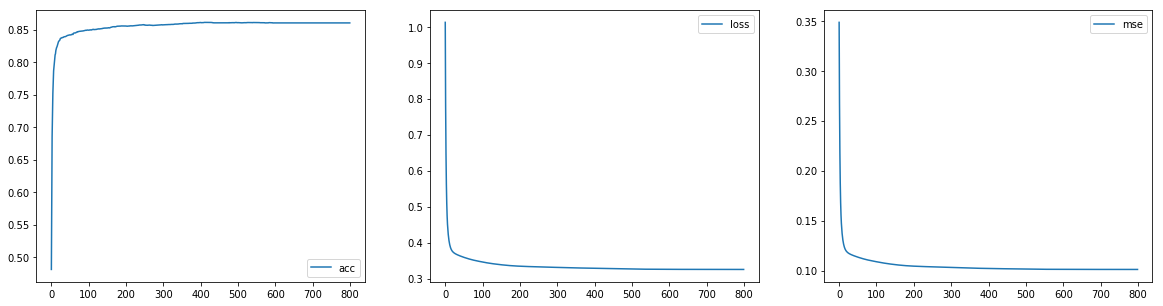

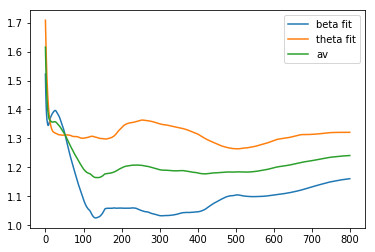

In [39]:
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="beta fit")
plt.plot(th_fit_rmses, label="theta fit")
plt.plot(av_fit_rmses, label="av")
plt.legend()
plt.show()
# fig = plt.gcf()
# fig.set_size_inches(8, 5)
# plt.xlabel("#iterations")
# plt.ylabel("fit error (RMSE)")
# plt.suptitle("Neural-MLTM Parameter Fitting")
# plt.title("(skills=5, items=10, students=100)")
# plt.legend()
# plt.show()

In [35]:
psi_wgts = s_table.get_weights()[0]
print(psi_wgts)
for psi in ss:
    print(psi.id, psi.thetas, psi_wgts[psi.id])
print("qs ====")
qn_wgts = q_table.get_weights()[0]
print(qn_wgts)
for qn in qs:
    print(qn.id, qn.betas, qn_wgts[qn.id])

[[  4.           6.11800337  11.          10.97501183   8.95020103]
 [ 11.           5.07528496  11.           4.00465775   4.15122032]
 [ 11.          11.           6.55451679  11.           6.27464581]
 [  4.00174046   6.3338666   11.          11.          11.        ]
 [  6.2410531   11.          11.          11.           8.88578224]
 [ 11.           6.47403812  11.          11.          11.        ]
 [ 11.          11.           5.83927822   4.47667265   6.40111828]
 [ 11.           5.83804989  11.          11.           4.9871006 ]
 [ 11.          11.          11.          11.          11.        ]
 [ 11.          11.          11.           4.2178998   11.        ]
 [ 11.           7.09730244   5.45723104   5.34542036   5.74580717]
 [  5.70590734   4.94917059   6.18828297  11.          11.        ]
 [ 11.          11.          10.06836224  11.           5.01989889]
 [  4.58772278   4.          10.99779892  11.           5.51806927]
 [ 11.           4.          11.           6.104

In [ ]:
n_traits = 5
nn_dimensions = [1,3,5,7,9]
serieses = []
min_errs = []
n_qs = 10
n_students = 100
for ix,nnw in enumerate(nn_dimensions):
    qs = create_qs(n_qs, n_traits, nnw, optimiser=qopt)
    ss = create_students(n_students, n_traits, nnw, optimiser=qopt)
    attempts_by_psi, attempts_by_q = generate_attempts(qs,ss)
    print(qs[0].pred_betas.get_weights()[0][0])
    print(ss[0].pred_theta.get_weights()[0][0])
    resultz = calibrate(qs,ss,attempts_by_q, attempts_by_psi, n_iter=70)
    serieses.append( resultz )
#     if ix < len(serieses): #append to old series
#         (_mses,_accs) = serieses[ix]
#         _mses += mses
#         _accs += accs
#         serieuses[ix] = (_mses,_accs)
#     else: #create new series
#         serieses.append((mses,accs))
    
from pygame import mixer
mixer.init()
mixer.music.load('calibration_complete.mp3')
mixer.music.play()

In [ ]:
# import pickle
# pickle.dump( serieses, open( "serieses.p", "wb" ) )

xmax=10
xs = range(len(serieses[0][0]))[0:xmax]
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=3, ncols=2)
print(axes.shape)
for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    axes[0,0].plot(xs, numpy.multiply(1,mses[0:xmax]), c, label="nnw={}".format(d))
    axes[0,1].plot(xs, numpy.multiply(1,accs[0:xmax]), c, label="nnw={}".format(d))
    axes[1,0].plot(xs, numpy.multiply(1,th_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[1,1].plot(xs, numpy.multiply(1,th_accs[0:xmax]), c, label="nnw={}".format(d))
    axes[2,0].plot(xs, numpy.multiply(1,b_mses[0:xmax]), c, label="nnw={}".format(d))
    axes[2,1].plot(xs, numpy.multiply(1,b_accs[0:xmax]), c, label="nnw={}".format(d))

# plt.plot(xs, accs, "m")
# plt.plot(xs, numpy.multiply(1,s_outer_accs), "g")7
# plt.plot(xs, numpy.multiply(1,q_outer_accs), "k")

# plt.plot(xs, numpy.multiply(1,mses), "m--")
# plt.plot(xs, numpy.multiply(1,s_outer_mses), "g--")
# plt.plot(xs, numpy.multiply(1,q_outer_mses), "k--")
for ix in range(axes.shape[0]):
    subcats = ["Combined","Student","Question"]
    for iy in range(axes.shape[1]):
        axes[ix,iy].set_xlabel("#iterations")
        axes[ix,iy].legend()
        if iy==0:
            axes[ix,iy].set_title("{} fit error".format(subcats[ix]))
            axes[ix,iy].set_ylabel("fit error (RMSE)")
        else:
            axes[ix,iy].set_title("{} fit accuracy".format(subcats[ix]))
            axes[ix,iy].set_ylabel("prediction accuracy")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18, 18)

fig.show()

In [ ]:
xs = range(len(serieses[0][0]))
print(len(serieses))
for s in serieses:
    print(len(s))
# plt.plot(xs, numpy.multiply(1,theta_rmses), 'b--')
# plt.plot(xs, numpy.multiply(1,beta_rmses), 'b')
fig, axes = plt.subplots(nrows=1, ncols=2)
print(axes.shape)

min_mses = []
max_accs = []
bmin_mses = []
bmax_accs = []

for (mses,accs, th_mses,th_accs, b_mses,b_accs),c,d in zip(serieses,["r--","y--","k-","c--","b--"],nn_dimensions):
    mm = min(th_mses)
    ma = max(th_accs)
    min_mses.append(mm)
    max_accs.append(ma)
    mm = min(b_mses)
    ma = max(b_accs)
    bmin_mses.append(mm)
    bmax_accs.append(ma)
    

axes[0].plot(nn_dimensions, numpy.multiply(1,min_mses))
axes[0].plot(nn_dimensions, numpy.multiply(1,bmin_mses))
axes[1].plot(nn_dimensions, numpy.multiply(1,max_accs))
axes[1].plot(nn_dimensions, numpy.multiply(1,bmax_accs))
axes[0].axvline(x=5, linestyle="--")
axes[1].axvline(x=5, linestyle="--")

fig.suptitle("Neural-MLTM Parameter Fitting (k={}, q={}, s={})".format(n_traits, n_qs, n_students))
fig.set_size_inches(18,4)

fig.show()